In [1]:
import numpy as np
import scipy as sp 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
def single_run(d_easy, d_hard, theta, var, ns, verbose=False):
    test_on_all = True

    # data distribution
    cov_all, cov_easy_no, cov_hard_no = var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard)
    covs = [cov_easy_no, cov_hard_no, cov_all] # all the same for now

    n_tot_train  = np.sum(ns)
    n_tot_pseudo = np.sum(ns) # pseudolabel set
    n_tot_test   = np.sum(ns) # test set for final eval
    X_train   = np.zeros([n_tot_train, d_easy + d_hard]) # data matrix
    X_pseudo  = np.zeros([n_tot_pseudo, d_easy + d_hard]) # data matrix
    X_test    = np.zeros([n_tot_test, d_easy + d_hard]) # data matrix

    y_train, y_pseudo, y_test = np.zeros(n_tot_train), np.zeros(n_tot_pseudo), np.zeros(n_tot_test)
    idx, j = 0, 0

    for n in ns:
        # gaussian samples
        pts_train = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        pts_pseudo = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        pts_test = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
        for i in range(n):
            # generate the labels for all the sets. binary labels uniform prior
            y_train[idx+i] = np.random.randint(2)
            y_pseudo[idx+i] = np.random.randint(2)
            y_test[idx+i] = np.random.randint(2)

            if y_train[idx+i]:
                pts_train[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_train[i] -= theta #np.ones(d_easy + d_hard) 
            if y_pseudo[idx+i]:
                pts_pseudo[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_pseudo[i] -= theta #np.ones(d_easy + d_hard) 
            if y_test[idx+i]:
                pts_test[i] += theta #np.ones(d_easy + d_hard) 
            else:
                pts_test[i] -= theta #np.ones(d_easy + d_hard) 

        X_train[idx:idx+n], X_pseudo[idx:idx+n], X_test[idx:idx+n] = pts_train, pts_pseudo, pts_test
        if j == 0: # easy only
            X_train[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
            X_pseudo[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
            X_test[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
        elif j == 1: # hard only
            X_train[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
            X_pseudo[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
            X_test[idx:idx+n,:d_easy] = np.zeros([n, d_easy])

        idx += n
        j += 1
    
    # simulate a weak model that cannot take advantage of hard features by zeroing features
    X_weak_train = np.copy(X_train)
    X_weak_train[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    X_weak_pseudo = np.copy(X_pseudo)
    X_weak_pseudo[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    X_weak_test = np.copy(X_test)
    X_weak_test[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

    # train classifiers
    weak_model = LogisticRegression(random_state=0).fit(X_weak_train, y_train)
    weak_train_acc_overall = weak_model.score(X_weak_train, y_train)

    if test_on_all:
        weak_test_acc_overall  = weak_model.score(X_weak_test, y_test)
    else:
        # test on hard for debugging 
        weak_test_acc_overall  = weak_model.score(X_weak_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])


    # how good was the accuracy on just easy points?
    weak_train_acc_easy = weak_model.score(X_weak_train[:ns[0]], y_train[:ns[0]])
    if verbose:
        print(f"weak model train acc on easy alone = {weak_train_acc_easy}")

    # how good was the accuracy on just overlaps?
    weak_train_acc_overlaps = weak_model.score(X_weak_train[ns[0]+ns[1]:], y_train[ns[0]+ns[1]:])
    if verbose:
        print(f"weak model train acc on overlaps = {weak_train_acc_overlaps}") 

    # oracle
    strong_model_oracle = LogisticRegression(random_state=0).fit(X_train, y_train)
    if test_on_all:
        strong_test_acc_oracle = strong_model_oracle.score(X_test, y_test)
    else:
        strong_test_acc_oracle = strong_model_oracle.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])

    # pseudolabels generated...
    y_pseudolabels = weak_model.predict(X_weak_pseudo)
    correct_easy = np.sum(y_pseudo[:ns[0]] == y_pseudolabels[:ns[0]])
    correct_overlaps = np.sum(y_pseudo[ns[0]+ns[1]:] == y_pseudolabels[ns[0]+ns[1]:])
    if verbose:
        print(f"correct easy was {correct_easy} at this level acc = {correct_easy/ns[0]}")
        print(f"correct overlaps was {correct_overlaps} at this level acc = {correct_overlaps/ns[2]}")

    # hard only
    # strong_model = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
    strong_model_train_overlaps = LogisticRegression(random_state=0, C=0.01).fit(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
    
    # all for debugging. first one means no label noise!
    #strong_model_train_overlaps = LogisticRegression(random_state=0).fit(X_pseudo[ns[1]+ns[2]:], y_pseudo[ns[1]+ns[2]:])
    #weights = strong_model_train_overlaps.coef_
    #print(f"true weights = \n{theta[:d_easy]}\n{theta[d_easy:2*d_easy]}")
    #print(f"lrnd weights = \n{weights[0][:d_easy]}\n{weights[0][d_easy:2*d_easy]}")
    #print(f"learned weights ={weights}")

    strong_pseudo_acc_overlaps = strong_model_train_overlaps.score(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
    if verbose:
        print(f"strong model trained on overlaps, fitting on pseudo overlaps = {strong_pseudo_acc_overlaps}") 

    #strong_model_full = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
    #strong_pseudo_acc = strong_model_full.score(X_pseudo, y_pseudo)
    #print(f"strong model trained on all pseudolabels, fitting on all pseudo= {strong_pseudo_acc}") 

    strong_pseudo_acc_pseudo_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudolabels[:ns[0]])
    strong_pseudo_acc_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudo[:ns[0]])
    strong_pseudo_acc_hard = strong_model_train_overlaps.score(X_pseudo[ns[1]:ns[1]+ns[2]], y_pseudo[ns[1]:ns[1]+ns[2]])
    if verbose:
        print(f"strong model train overlaps test on pseudo easy = {strong_pseudo_acc_pseudo_easy}") 
        print(f"strong model train overlaps test on true easy = {strong_pseudo_acc_easy}") 
        print(f"strong model train overlaps test on true hard = {strong_pseudo_acc_hard}") 

    if test_on_all:
        strong_model_test_acc = strong_model_train_overlaps.score(X_test, y_test)
    else:
        strong_model_test_acc = strong_model_train_overlaps.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])
    if verbose:
        print(f"All points strong model acc = {strong_model_test_acc}")
        print()
    return [weak_test_acc_overall, strong_test_acc_oracle, strong_model_test_acc]



In [3]:
#np.random.seed(0x1234)
tot_runs = 10

ratio = 1
d_easy = 10
d_hard = d_easy * ratio
total_overlap_choices = 10

var = 5.0
accs = np.zeros([total_overlap_choices-1, 3])
for j in range(tot_runs):
    theta = np.random.rand(d_easy + d_hard) # single parameter vector

    for overlap in range(1,total_overlap_choices):
        ns = [1000-overlap*100, 1000, 300+overlap*100] # easy non-overlap, hard non-overlap, overlaps. total points is always 400
        #ns = [1000, 1000, 300+overlap*100] # easy non-overlap, hard non-overlap, overlaps. total points is always 400
        accs[overlap-1] += single_run(d_easy, d_hard, theta, var, ns, verbose=False) 
    if j%10 == 0:
        print(f"finished run {j}")



finished run 0


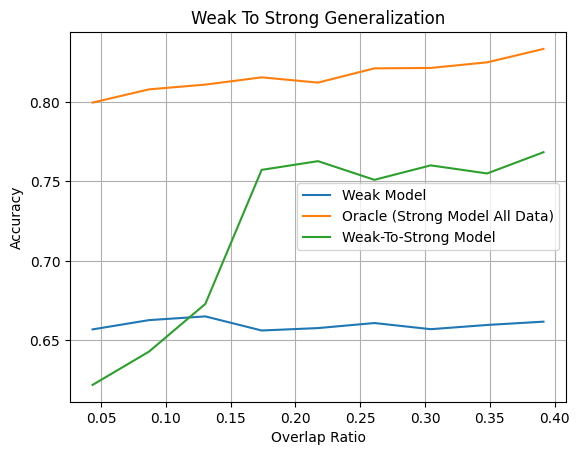

In [4]:
fig, ax = plt.subplots()
ax.plot([x * 100.0/np.sum(ns) for x in range(1,total_overlap_choices)], accs[:,0]/tot_runs)
ax.plot([x * 100.0/np.sum(ns) for x in range(1,total_overlap_choices)], accs[:,1]/tot_runs)
ax.plot([x * 100.0/np.sum(ns) for x in range(1,total_overlap_choices)], accs[:,2]/tot_runs)
ax.set(xlabel='Overlap Ratio', ylabel='Accuracy',
       title='Weak To Strong Generalization')
ax.legend(['Weak Model', 'Oracle (Strong Model All Data)', 'Weak-To-Strong Model'])
ax.grid()
plt.show()



In [5]:
accs[:,0]

array([6.56956522, 6.62782609, 6.65130435, 6.5626087 , 6.57782609,
       6.60956522, 6.57086957, 6.5973913 , 6.61826087])